# Компʼютерний практикум №8
Виконав студент групи ЗК-41мп Гломозда Костянтин

КЛАСИФІКАЦІЯ РУКОПИСНИХ ЧИСЕЛ ПОВНОЗВ’ЯЗНОЮ МЕРЕЖЕЮ. МЕТОДИ ОПТИМІЗАЦІЇ

# Завдання 1

Завантажуємо бібліотеки

In [93]:
import torch
import random
import numpy as np


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Завантаження датасету

In [94]:
import torchvision.datasets


MNIST_train = torchvision.datasets.MNIST('./data', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./data', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/dynokostya/Documents/Projects/nn-pytorch-labs/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Перевірка

In [95]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

print(X_train.dtype, y_train.dtype)

torch.uint8 torch.int64


Перетвоюємо дані на float

In [96]:
X_train = X_train.float()
X_test = X_test.float()

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])


Відобразимо картинку

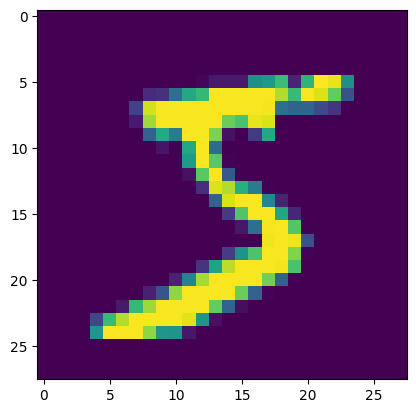

tensor(5, device='cuda:0')


In [97]:
import matplotlib.pyplot as plt


plt.imshow(X_train[0, :, :].cpu())
plt.show()
print(y_train[0])

Перевторюємо 2д в 1д масив

In [98]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

print(X_train.shape, X_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


Створюємо нейронну мережу на 784 входи та 10 виходів

In [99]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100).to(device)

Створюємо оптимізатор

In [100]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

Навчання

In [101]:
batch_size = 100
epochs = 100
test_accuracy = []
test_loss = []
train_accuracy = []
train_loss = []

for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        preds = mnist_net.forward(X_batch)
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()
    
    if epoch % (epochs / 10) == 0:
        # Test (validation)
        test_preds = mnist_net.forward(X_test)
        test_loss.append(loss(test_preds, y_test))
        test_accuracy.append((test_preds.argmax(dim=1) == y_test).float().mean())
        
        # Train
        train_preds = mnist_net.forward(X_train)
        train_loss.append(loss(train_preds, y_train))
        train_accuracy.append((train_preds.argmax(dim=1) == y_train).float().mean())
        
        print(f"Epoch: {epoch}/{epochs}, Test Accuracy: {test_accuracy[-1]:.03f}, Test Loss: {test_loss[-1]:.03f}, Train Accuracy: {train_accuracy[-1]:.03f}, Train Loss: {train_loss[-1]:.03f}")
        
print(f"Final Test Accuracy: {(test_preds.argmax(dim=1) == y_test).float().mean():.03f}")
print(f"Final Test Loss: {loss(test_preds, y_test):.03f}")
print(f"Final Train Accuracy: {(train_preds.argmax(dim=1) == y_train).float().mean():.03f}")
print(f"Final Train Loss: {loss(train_preds, y_train):.03f}")

Epoch: 0/100, Test Accuracy: 0.910, Test Loss: 0.343, Train Accuracy: 0.906, Train Loss: 0.352
Epoch: 10/100, Test Accuracy: 0.931, Test Loss: 0.229, Train Accuracy: 0.932, Train Loss: 0.226
Epoch: 20/100, Test Accuracy: 0.939, Test Loss: 0.209, Train Accuracy: 0.940, Train Loss: 0.197
Epoch: 30/100, Test Accuracy: 0.947, Test Loss: 0.184, Train Accuracy: 0.947, Train Loss: 0.178
Epoch: 40/100, Test Accuracy: 0.944, Test Loss: 0.186, Train Accuracy: 0.949, Train Loss: 0.168
Epoch: 50/100, Test Accuracy: 0.949, Test Loss: 0.162, Train Accuracy: 0.953, Train Loss: 0.152
Epoch: 60/100, Test Accuracy: 0.949, Test Loss: 0.160, Train Accuracy: 0.956, Train Loss: 0.143
Epoch: 70/100, Test Accuracy: 0.950, Test Loss: 0.164, Train Accuracy: 0.955, Train Loss: 0.145
Epoch: 80/100, Test Accuracy: 0.956, Test Loss: 0.143, Train Accuracy: 0.960, Train Loss: 0.132
Epoch: 90/100, Test Accuracy: 0.955, Test Loss: 0.147, Train Accuracy: 0.961, Train Loss: 0.128
Final Test Accuracy: 0.955
Final Test Los

Візуалізація результатів

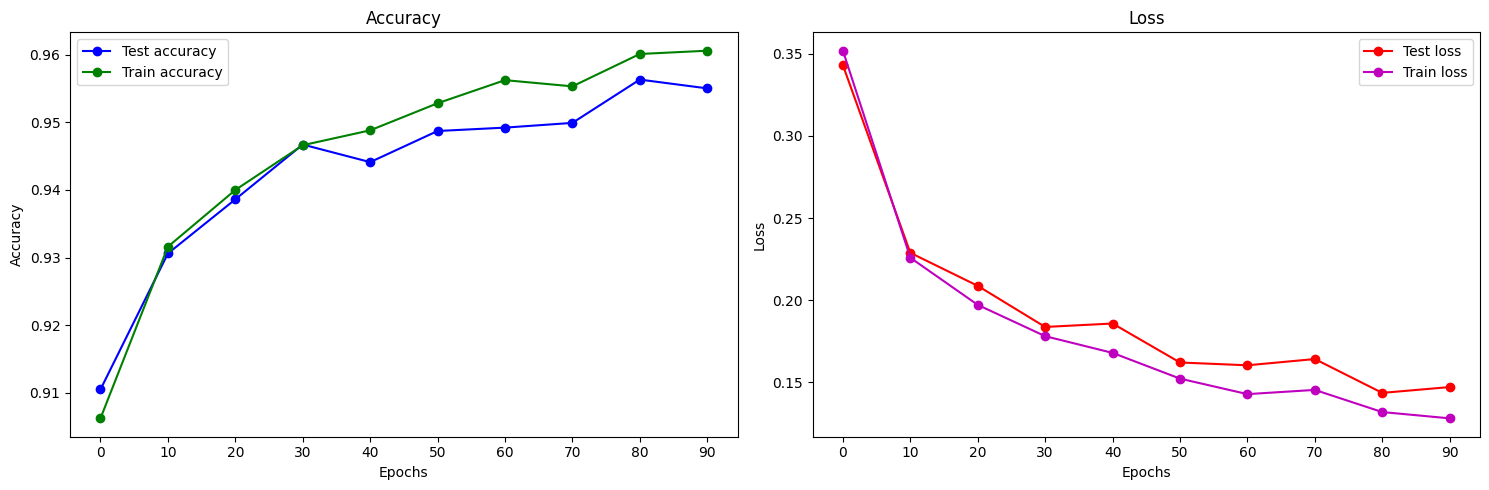

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axs[0].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), test_accuracy)), 'bo-', label='Test accuracy')
axs[0].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), train_accuracy)), 'go-', label='Train accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xticks(range(0, epochs, epochs // 10))
axs[0].legend()

# Loss
axs[1].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), test_loss)), 'ro-', label='Test loss')
axs[1].plot(range(0, epochs, epochs // 10), list(map(lambda x: x.cpu().detach(), train_loss)), 'mo-', label='Train loss')
axs[1].set_title('Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xticks(range(0, epochs, epochs // 10))
axs[1].legend()

plt.tight_layout()
plt.show()

Чи правда, що loss на train і validation падає однаково швидко і виходить на однакове значення, або ж у нас є перенавчання?

Чи веде збільшення кількості епох (з 40 епох до 200 епох) до поліпшення метрик на валідації?

Ні, 

Чи уповільнює torch.backends.cudnn.deterministic = True навчання
на практиці? Якщо так, то наскільки?

При значенні False навчання триває 23.1 секунди:
`
Final Test Accuracy: 0.955
Final Test Loss: 0.147
Final Train Accuracy: 0.961
Final Train Loss: 0.128
`
Значення True - 23.1 секунди:
`
Final Test Accuracy: 0.955
Final Test Loss: 0.147
Final Train Accuracy: 0.961
Final Train Loss: 0.128
`

Можливо зміни відсутні через те, що cuDNN не була встановлена додатково